# 🐾 AnimalCLEF2025 Competition: Official Starter notebook

The **Goal of the** [AnimalCLEF2025](https://www.kaggle.com/competitions/animal-clef-2025/) competition is to identify individual animal (lynxes, salamanders and sea turtles) in photos. This notebook visualize the provided dataset and propose a baseline solution, based on the state-of-the-art re-identification model [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). The dataset is split into the database and query sets. For each image from the query set, the goal is to:

- Predict whether the depicted individual is in the database.
- If no, the prediction is `new_individual`.
- If yes, the prediction should be the same as the individual in the database.

## Dependencies instalation
For the competition we provide two Python packages for loading and preprocessing of available datasets ([wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets)) and tools / method for animal re-identification ([wildlife-tools](https://github.com/WildlifeDatasets/wildlife-tools)).

In [1]:
!pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
!pip install git+https://github.com/WildlifeDatasets/wildlife-tools

  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to /tmp/pip-req-build-wvixl5_8
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets /tmp/pip-req-build-wvixl5_8
  Cloning https://github.com/WildlifeDatasets/wildlife-tools to /tmp/pip-req-build-38u0gp1o
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-tools /tmp/pip-req-build-38u0gp1o
  Resolved https://github.com/WildlifeDatasets/wildlife-tools to commit 71aa4656d16afe4caae6d84af642bab81dc2d06d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gluefactory-0.0-py3-none-any.whl
  Cloning https://github.com/cvg/LightGlue.git to /tmp/pip-install-r6klnrud/lightglue_8605390ceebd4f37b6487091d4506840
  Running command git clone --filter=blob:none --quiet https://github.com/cvg/LightGlue.git /tmp/pip-inst

## Dependencies import
We load all the required packages and then define the function `create_sample_submission`, which converts provided predictions and a submission file for the competition.

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import timm
import torch
from torch import nn
from torch.utils.data import SubsetRandomSampler, DataLoader
from itertools import chain
import torchvision.transforms as T
import clip
from wildlife_datasets.datasets import AnimalCLEF2025, WildlifeDataset
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity, MatchLightGlue
from wildlife_tools.inference import KnnClassifier
from wildlife_tools.train import ArcFaceLoss, BasicTrainer, TripletLoss
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

2025-03-18 23:03:46.641464: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [32]:
x = [1, 2, 1, 1, -1, 3, 4]
y = [1, 1, 1, 2, 5, 4, 4]
balanced_accuracy_score(x, y)

/home/xbar19/ML/MLEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.3333333333333333

In [117]:
pd.read_csv('animal-clef-2025/submissions/knn1.csv')['identity'].value_counts()

identity
new_individual          774
LynxID2025_lynx_32       68
LynxID2025_lynx_62       60
LynxID2025_lynx_49       46
LynxID2025_lynx_43       38
                       ... 
SalamanderID2025_222      1
SalamanderID2025_223      1
SalamanderID2025_224      1
SalamanderID2025_228      1
SeaTurtleID2022_t410      1
Name: count, Length: 421, dtype: int64

In [16]:
t = np.array([1, 1, 1, 2, -1, 4, 4])

In [20]:
np.where(t != -1)[0]

array([0, 1, 2, 3, 5, 6])

In [15]:
from scipy.stats import gmean

def metric(x, y, labels):
    new = [c for c in set(y) if c not in set(labels)]
    is_new = lambda k: -1 if k in new else k
    y = [is_new(c) for c in y]
    x = np.array(x)
    y = np.array(y)
    c_idx = np.where(y != -1)[0]
    new_idx = np.where(y == -1)[0]
    x_c = x[c_idx]
    x_n = x[new_idx]
    y_c = y[c_idx]
    y_n = y[new_idx]

    return gmean([balanced_accuracy_score(x_c, y_c), balanced_accuracy_score(x_n, y_n)])

We need to specify the `root`, where the data are stored and then two image transformations. 
1. The first transform only resizes the images and is used for visualization.
2. The second transform also converts it to torch tensor and is used for operations on neural networks.

In [35]:
root = 'animal-clef-2025/'
transform_display = T.Compose([
    T.Resize([384, 384]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

In [2]:
root = 'animal-clef-2025/'
transform_display = T.Compose([
    T.Resize([256, 256], interpolation=T.InterpolationMode.BILINEAR),
    T.CenterCrop([224, 224])
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

### 📊 Visualizing Data

Since `AnimalCLEF2015` is the child class of `datasets.WildlifeDataset` from [wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets/blob/main/wildlife_datasets/datasets/datasets.py), it inherits all its methods and attributes. The following code specify which `transform` we want to use while loading images and that we want to load labels alongside images.

In [3]:
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

📌 **Plotting a sample grid** of the data. We can see that all animals in the testing sets are turtles. The column `dataset` states that all the photos come from the SeaTurtleID2022 dataset.

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


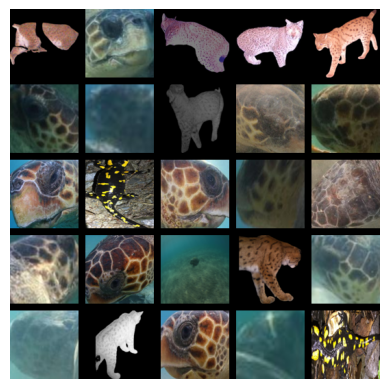

In [52]:
dataset.plot_grid(n_cols=5)
dataset.metadata

This is confirmed by showing all datasets from which the data is composed of.

In [7]:
dataset.metadata[['dataset', 'split']].value_counts()

dataset           split   
SeaTurtleID2022   database    8729
LynxID2025        database    2957
SalamanderID2025  database    1388
LynxID2025        query        946
SalamanderID2025  query        689
SeaTurtleID2022   query        500
Name: count, dtype: int64

Now, we can plot the data of any dataset. Here we do it for the SeaTurtleID2022. The images are the same as in the query set. The goal for each image from the query set will be to determine its identity from the database (it will always be in the form `SeaTurtleID2022_t???` or to decide that it is a new individual (it is not present in the database).

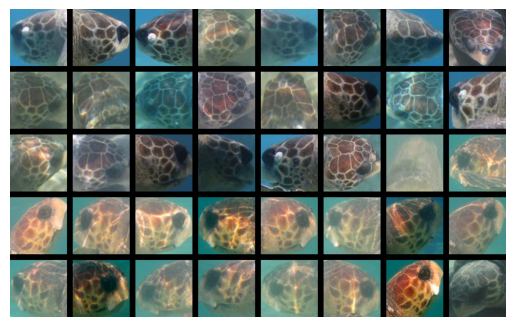

In [8]:
idx = dataset.metadata['identity'].str.startswith('SeaTurtleID2022')
idx[idx.isnull()] = False
dataset.plot_grid(idx=idx);

## Inference with MegaDescriptor

Instead of training a classifier, we can just use out of the shelf pretrained models - [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). We use MegaDescriptor to extract features from all images. 

**Note:** _It is highly recommended to use the GPU acceleration._

In [84]:
cmodel, preprocess = clip.load("ViT-B/32", device='cuda')

In [4]:
# Loading the dataset
dataset = AnimalCLEF2025(root, transform=transform, load_label=True)
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
n_query = len(dataset_query)

In [79]:
# Loading the dataset
dataset = AnimalCLEF2025(root, transform=preprocess, load_label=True)
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
n_query = len(dataset_query)

In [6]:
metadata = dataset_database.metadata.copy()

In [7]:
metadata = metadata[metadata['species'] == 'lynx']

In [8]:
lbl2int = {lbl: i for i, lbl in enumerate(metadata['identity'].unique())}
int2lbl = {i: lbl for i, lbl in enumerate(metadata['identity'].unique())}

In [9]:
len(dataset_database.labels_string)

13074

In [10]:
len(lbl2int)

77

In [11]:
max(int2lbl.keys())

76

In [58]:
metadata

,image_id,identity,path,date,orientation,species,split,dataset
0,0,0,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,0,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,1,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,4,2,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
4,6,3,images/LynxID2025/database/0051adb5bd1b63867b9...,NaN,left,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
2952,3895,41,images/LynxID2025/database/ff968c75d2c8b8b37d4...,NaN,right,lynx,database,LynxID2025
2953,3896,5,images/LynxID2025/database/ffb875184fefa89a9dc...,NaN,left,lynx,database,LynxID2025
2954,3898,26,images/LynxID2025/database/ffc5b76999fe8bc20ce...,NaN,left,lynx,database,LynxID2025
2955,3899,9,images/LynxID2025/database/ffd7b56e60a2b001ac1...,NaN,right,lynx,database,LynxID2025


In [12]:
metadata['identity'] = metadata['identity'].map(lbl2int)

In [13]:
wdataset = WildlifeDataset(metadata=metadata, root=root, transform=transform, load_label=True)

In [65]:
wdataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [70]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [16]:
model = timm.create_model('densenet121', pretrained=True, num_classes=0)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/densenet121.ra_in1k)
INFO:timm.models._hub:[timm/densenet121.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [16]:
criterion = TripletLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [104]:
torch.randint(1, 10, (4,))

tensor([4, 2, 4, 8])

In [ ]:
criterion(model(torch.randn(16, 3, 224, 224)), torch.randint(1, 10000, (16,)))


KeyboardInterrupt



In [14]:
tqdm?

Init signature: tqdm(*_, **__)
Docstring:     
Decorate an iterable object, returning an iterator which acts exactly
like the original iterable, but prints a dynamically updating
progressbar every time a value is requested.

Parameters
----------
iterable  : iterable, optional
    Iterable to decorate with a progressbar.
    Leave blank to manually manage the updates.
desc  : str, optional
    Prefix for the progressbar.
total  : int or float, optional
    The number of expected iterations. If unspecified,
    len(iterable) is used if possible. If float("inf") or as a last
    resort, only basic progress statistics are displayed
    (no ETA, no progressbar).
    If `gui` is True and this parameter needs subsequent updating,
    specify an initial arbitrary large positive number,
    e.g. 9e9.
leave  : bool, optional
    If [default: True], keeps all traces of the progressbar
    upon termination of iteration.
    If `None`, will leave only if `position` is `0`.
file  : `io.TextIOWrappe

In [19]:
len(dataset_query) / len(dataset_database)

0.16330120850543062

In [21]:
tr

In [20]:
tr, val = torch.utils.data.random_split(wdataset, [0.83, 0.17])

In [22]:
train_loader = DataLoader(tr, batch_size=8, shuffle=True)
val_loader = DataLoader(val, batch_size=8, shuffle=False)

In [28]:
from wildlife_tools.data import FeatureDataset

In [30]:
FeatureDataset??

Init signature:
FeatureDataset(
    features: list,
    metadata: pandas.core.frame.DataFrame,
    col_label: str = 'identity',
    load_label: bool = True,
)
Source:        
class FeatureDataset:
    """
    PyTorch-style dataset for a extracted features. Couples features with metadata.

    Args:
        features: list, np.array or tensor of features. Index of features should match with metadata.
        metadata: A pandas dataframe containing features metadata.
        col_label: Column name in the metadata containing class labels.
        load_label: If False, \_\_getitem\_\_ returns only image instead of (image, label) tuple.

    Attributes:
        labels np.array : An integers array of ordinal encoding of labels.
        labels_string np.array: A strings array of original labels.
        labels_map dict: A mapping between labels and their ordinal encoding.
        num_classes int: Return the number of unique classes in the dataset.
    """

    def __init__(
        self,
     

In [25]:
device = 'cuda'
model = model.to(device)

for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    val_epoch_loss = 0.0
    correct = 0
    total = 0
    epoch_labels = []
    tk_train = tqdm(train_loader, 'Epoch {}'.format(epoch))

    for batch in tk_train:
        images, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        features_database = model(images)
        
        loss = criterion(features_database, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_labels += labels.detach().cpu().numpy().tolist()
        
        
        

    model.eval()
    tk_val = tqdm(val_loader, 'Validation')
    for batch in tk_val:
        images, labels = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            features_query = model(images)
            val_loss = criterion(features_query, labels).item()
            val_epoch_loss += val_loss
            
        knn_model = KnnClassifier(k=3, database_labels=dataset_database.labels_string, return_scores=True)
        similarity = CosineSimilarity()(features_query, features_database)
        preds = knn_model(similarity)
        preds[0] = preds[0].astype(int)
        thd0 = 0.05
        bst_score = float('-inf')
        bst_thd = 0.05
        
        for i in range(1, 21):
            thd = thd0 * i
            preds[0][preds[1] < thd] = -1
            score = metric(preds[0], labels.cpu().numpy(), epoch_labels)
            if score > bst_score:
                bst_score = score
                bst_thd = thd
            tk_val.set_postfix_str(f'Best thd: {bst_thd}, Best metric: {bst_score}')
        
        # Вычисление Accuracy
        # _, predicted = torch.max(features, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

    # accuracy = correct / total
    print(f"Epoch {epoch+1}, Train_Loss: {epoch_loss / len(train_loader)}, Val_Loss: {val_epoch_loss/len(val_loader)}, Val_Score: {score}, Best Threshold: {bst_thd}")

Validation:   0%|                                                                                | 0/63 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'features'

In [13]:
np.array(['1', '3']).astype(int)

array([1, 3])

In [35]:
#Loading the model
# name = 'hf-hub:BVRA/MegaDescriptor-L-384'
name = 'hf-hub:BVRA/MegaDescriptor-B-224'
device = 'cuda'
model = timm.create_model(name, num_classes=0, pretrained=True)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (BVRA/MegaDescriptor-B-224)
/home/xbar19/ML/MLEnv/lib/python3.10/site-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for

In [66]:
from transformers import AutoModel

In [67]:
model = AutoModel.from_pretrained('openai/clip-vit-base-patch16')

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [71]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ttmuo_uk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ttmuo_uk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=e958de3d6c717185dd73b64a3e63a50af0c25a8ae483c00716c254e7a3462295
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmeta98l/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [77]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f885fcfc280>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [69]:
model(pixel_values=dataset_database[0][0].unsqueeze(0))

ValueError: You have to specify input_ids

In [65]:
#Loading the model
# name = 'hf-hub:BVRA/MegaDescriptor-L-384'
name = 'hf-hub:openai/clip-vit-base-patch16'
device = 'cuda'
model = timm.create_model(name, num_classes=0, pretrained=True)

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

KeyError: 'architecture'

In [87]:
cmodel

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [89]:
cmodel.encode_image(dataset_database[0][0].unsqueeze(0).cuda()).shape

torch.Size([1, 512])

In [90]:
class CLIPModel(nn.Module):
    def __init__(self, model):
        super(CLIPModel, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model.encode_image(x)

In [91]:
model = CLIPModel(cmodel)

In [44]:
extractor = DeepFeatures(model, device='cuda', batch_size=8, num_workers=0)
features_database = extractor(dataset_database)
features_query = extractor(dataset_query)

100%|█████████████████████████████████████████████████████████████| 267/267 [01:15<00:00,  3.56it/s]


In [50]:
features_database.features[0]

array([0.03263624, 0.3896633 , 0.5962462 , ..., 0.08048963, 0.04088793,
       0.        ], dtype=float32)

In [37]:
dataset_database.labels_string

array(['LynxID2025_lynx_37', 'LynxID2025_lynx_37', 'LynxID2025_lynx_49',
       ..., 'SeaTurtleID2022_t610', 'SeaTurtleID2022_t610',
       'SeaTurtleID2022_t610'], dtype=object)

In [67]:
from sklearn.cluster import HDBSCAN

# Извлечение признаков для тестового набора
# features_query = extractor(dataset_query)

# Применение DBSCAN
clustering = HDBSCAN(min_samples=2).fit_predict(features_query.features)
# labels_cluster = clustering.labels_

# Определение новых особей
new_individual_mask = (clustering == -1)

In [70]:
pd.Series(clustering).value_counts()

 0    2106
-1      23
 1       6
Name: count, dtype: int64

In [14]:
features_query = extractor(dataset_query)

100%|███████████████████████████████████████████████████████████████| 67/67 [08:53<00:00,  7.96s/it]


In [18]:
with torch.no_grad():
    emb_size = model(dataset_database[0][0].unsqueeze(0)).shape[1]

In [15]:
from wildlife_tools.inference import TopkClassifier

In [37]:
s = 2 ** 0.5 * np.log(dataset_database.num_classes - 1)

In [38]:
obj = ArcFaceLoss(embedding_size=emb_size, num_classes=dataset_database.num_classes, scale=s, margin=0.3)

In [12]:
KnnClassifier??

Init signature:
KnnClassifier(
    database_labels: 'np.array',
    k: 'int' = 1,
    return_scores=False,
)
Source:        
class KnnClassifier:
    """
    Predict query label as k labels of nearest matches in the database.
    If there is a tie at a given k, the prediction with the best score is used.
    """

    def __init__(self, database_labels: np.array, k: int = 1, return_scores=False):
        """
        Args:
            database_labels (np.array): Array containing the labels of the database.
            k (int): The number of nearest neighbors to consider.
            return_scores (bool): Indicates whether to return scores along with predictions.
        """
        self.k = k
        self.database_labels = database_labels
        self.return_scores = return_scores

    def __call__(self, similarity):
        """
        Predicts the label for each query based on the k nearest matches in the database.

        Args:
            similarity: A 2D similarity matrix with `n_q

In [39]:
loader = torch.utils.data.DataLoader(wdataset, batch_size=16, shuffle=True)

In [86]:
wdataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [90]:
import gc

gc.collect()

8824

In [22]:
params = chain(model.parameters(), obj.parameters())

In [23]:
optimizer = torch.optim.SGD(params=params, lr=0.00001, momentum=0.9)

In [48]:
model = model.to('cuda').train()
for e in range(10):
    losses = []
    tk = tqdm(loader, desc=f"Epoch {e}: ", mininterval=1, ncols=100)
    for i, batch in enumerate(tk):
        x, y = batch
        x, y = x.to('cuda'), y.to('cuda')
    
        out = model(x)
        loss = objective(out, y)
        loss.backward()
        # if (i - 1) % self.accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach().cpu())
        tk.set_postfix_str(f'Epoch Loss: {sum(losses) / len(losses)}')
    
    
    # if self.scheduler:
    #     self.scheduler.step()

Epoch 2:  15%|███▏                  | 27/185 [00:41<04:05,  1.55s/it, Epoch Loss: 3.479522943496704]

KeyboardInterrupt



In [24]:
params = chain(model.parameters(), obj.parameters())

In [25]:
optimizer = torch.optim.SGD(params, lr=0.00001)
min_lr = optimizer.defaults.get("lr") * 1e-3
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=min_lr)

In [27]:
def epoch_callback(trainer, epoch_data):
    print(epoch_data['train_loss_epoch_avg'])

In [26]:
BasicTrainer??

Init signature:
BasicTrainer(
    dataset,
    model,
    objective,
    optimizer,
    epochs,
    scheduler=None,
    device='cuda',
    batch_size=128,
    num_workers=1,
    accumulation_steps=1,
    epoch_callback=None,
)
Source:        
class BasicTrainer:
    """
    Implements basic training loop for Pytorch models.
    Checkpoints includes random states - any restarts from checkpoint preservers reproducibility.

    Args:
        dataset ():
            Training dataset that gives (x, y) tensor pairs.
        model (dict):
            Pytorch nn.Module for model / backbone.
        objective (dict):
            Pytorch nn.Module for objective / loss function.
        optimizer:
            Pytorch optimizer.
        scheduler (optional):
            Pytorch scheduler.
        epochs (int):
            Number of training epochs.
        device (str, default: 'cuda'):
            Device to be used for training.
        batch_size (int, default: 128):
            Training batch s

In [39]:
trainer = BasicTrainer(
    dataset=wdataset,
    batch_size=8,
    device='cuda',
    epochs=15,
    optimizer=optimizer,
    model=model,
    objective=obj,
    epoch_callback=epoch_callback
)

In [183]:
wdataset.load_label

1

In [177]:
wdataset[0].shape

torch.Size([3, 384, 384])

In [59]:
len(wdataset)

13074

In [30]:
torch.cuda.empty_cache()

In [40]:
trainer.train()

Epoch 0: 100%|████████████████████████████████████████████████████| 370/370 [01:04<00:00,  5.71it/s]


9.986414


Epoch 1: 100%|████████████████████████████████████████████████████| 370/370 [01:10<00:00,  5.23it/s]


9.989435


Epoch 2: 100%|████████████████████████████████████████████████████| 370/370 [01:11<00:00,  5.14it/s]


9.983749


Epoch 3: 100%|████████████████████████████████████████████████████| 370/370 [01:10<00:00,  5.28it/s]


9.986638


Epoch 4: 100%|████████████████████████████████████████████████████| 370/370 [01:12<00:00,  5.12it/s]


9.979316


Epoch 5: 100%|████████████████████████████████████████████████████| 370/370 [01:09<00:00,  5.30it/s]


9.980747


Epoch 6: 100%|████████████████████████████████████████████████████| 370/370 [01:13<00:00,  5.02it/s]


9.977737


Epoch 7: 100%|████████████████████████████████████████████████████| 370/370 [01:13<00:00,  5.05it/s]


9.977966


Epoch 8:   8%|████▎                                                | 30/370 [00:04<00:54,  6.25it/s]

KeyboardInterrupt



In [41]:
model = trainer.model

In [42]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

In [136]:
for batch in dataset_database:
    x, y = batch
    print(y)
    break

LynxID2025_lynx_37


In [52]:
dataset_database.labels_string

array(['LynxID2025_lynx_37', 'LynxID2025_lynx_37', 'LynxID2025_lynx_49',
       ..., 'SeaTurtleID2022_t610', 'SeaTurtleID2022_t610',
       'SeaTurtleID2022_t610'], dtype=object)

Here we extract the similarity between the images. The similarity equals to the cosine similarity between the corresponding feature vectors. Since the cosine similarity reflects the angle between the feature vectors, high similarity means that the feature vectors are close to each other and should depict the same individual.

In [71]:
similarity = CosineSimilarity()(features_query, features_database)

For each query image we extract the closest image as predicted by MegaDescriptor. Their indices are stored in `pred_idx` and the similarity score of the top match in `pred_scores`.

In [72]:
pred_idx = similarity.argsort(axis=1)[:,-1]
pred_scores = similarity[range(n_query), pred_idx]

In [73]:
pred_scores

array([0.5634945 , 0.68294775, 0.6142883 , ..., 0.88076   , 0.830066  ,
       0.8373496 ], dtype=float32)

In [33]:
from wildlife_tools.train import TripletLoss, SoftmaxLoss

In [39]:
TripletLoss??

Init signature:
TripletLoss(
    margin: int = 0.2,
    mining: str = 'seminard',
    distance: str = 'l2_squared',
)
Source:        
class TripletLoss(nn.Module):
    """
    Wraps Pytorch Metric Learning TripletMarginLoss.

    Args:
        margin (int): Margin for triplet loss.
        mining (str): Type of triplet mining. One of: 'all', 'hard', 'semihard'
        distance (str): Distance metric for triplet loss. One of: 'cosine', 'l2', 'l2_squared'

    """

    def __init__(self, margin: int = 0.2, mining: str = "seminard", distance: str = "l2_squared"):
        super().__init__()
        if distance == "cosine":
            distance = distances.CosineSimilarity()
        elif distance == "l2":
            distance = distances.LpDistance(normalize_embeddings=True, p=2, power=1)
        elif distance == "l2_squared":
            distance = distances.LpDistance(normalize_embeddings=True, p=2, power=2)
        else:
            raise ValueError(f"Invalid distance: {distance}")

    

In [36]:
ArcFaceLoss??

Init signature:
ArcFaceLoss(
    num_classes: int,
    embedding_size: int,
    margin: int = 0.5,
    scale: int = 64,
)
Source:        
class ArcFaceLoss(nn.Module):
    """
    Wraps Pytorch Metric Learning ArcFaceLoss.

    Args:
        num_classes (int): Number of classes.
        embedding_size (int): Size of the input embeddings.
        margin (int): Margin for ArcFace loss (in radians).
        scale (int): Scale parameter for ArcFace loss.
    """

    def __init__(self, num_classes: int, embedding_size: int, margin: int = 0.5, scale: int = 64):
        super().__init__()
        self.loss = losses.ArcFaceLoss(
            num_classes=num_classes,
            embedding_size=embedding_size,
            margin=57.3 * margin,
            scale=scale,
        )

    def forward(self, embeddings, y):
        return self.loss(embeddings, y)
File:           ~/ML/MLEnv/lib/python3.10/site-packages/wildlife_tools/train/objective.py
Type:           type
Subclasses:     

In [38]:
BasicTrainer??

Init signature:
BasicTrainer(
    dataset,
    model,
    objective,
    optimizer,
    epochs,
    scheduler=None,
    device='cuda',
    batch_size=128,
    num_workers=1,
    accumulation_steps=1,
    epoch_callback=None,
)
Source:        
class BasicTrainer:
    """
    Implements basic training loop for Pytorch models.
    Checkpoints includes random states - any restarts from checkpoint preservers reproducibility.

    Args:
        dataset ():
            Training dataset that gives (x, y) tensor pairs.
        model (dict):
            Pytorch nn.Module for model / backbone.
        objective (dict):
            Pytorch nn.Module for objective / loss function.
        optimizer:
            Pytorch optimizer.
        scheduler (optional):
            Pytorch scheduler.
        epochs (int):
            Number of training epochs.
        device (str, default: 'cuda'):
            Device to be used for training.
        batch_size (int, default: 128):
            Training batch s

This is sufficient to perform predictions as shown below in `predictions`. However, we also need to predict whether the individual is new. We utilize the simplest idea and predict that the individual is new whenever the similarity score of the top prediction is below a certain threshold which we arbirtarily selected as 0.6. We create a submission file, which scores 30.0% on the public leaderboard.

In [75]:
np.quantile(pred_scores, 0.35)

0.6747166037559509

In [76]:
pred_scores.std()

0.14334434

In [108]:
threshold = 0.6

In [27]:
pred_scores.max()

1.0000006

In [30]:
len(dataset_database.labels_string)

13074

In [86]:
knn_model = KnnClassifier(k=3, database_labels=dataset_database.labels_string, return_scores=True)

In [91]:
preds = knn_model(similarity)

In [79]:
preds[1]

array([0.55475736, 0.67703092, 0.61428827, ..., 0.88076001, 0.83006603,
       0.83734959])

In [112]:
preds[1].std()

0.017020315858702326

In [80]:
preds[0]

array(['LynxID2025_lynx_32', 'LynxID2025_lynx_32', 'LynxID2025_lynx_95',
       ..., 'SeaTurtleID2022_t082', 'SeaTurtleID2022_t008',
       'SeaTurtleID2022_t388'], dtype='<U20')

In [92]:
preds[0][preds[1] < np.quantile(preds[1], 0.3635)] = 'new_individual'

In [44]:
preds[0][preds[1] < threshold] = 'new_individual'

In [45]:
sum(predictions == preds[0]) / len(predictions)

NameError: name 'predictions' is not defined

In [93]:
pd.Series(preds[0]).value_counts()

new_individual          776
LynxID2025_lynx_49       21
LynxID2025_lynx_95       17
LynxID2025_lynx_32       17
LynxID2025_lynx_62       15
                       ... 
SalamanderID2025_432      1
SalamanderID2025_215      1
SalamanderID2025_513      1
SalamanderID2025_52       1
SeaTurtleID2022_t544      1
Name: count, Length: 513, dtype: int64

In [40]:
pd.Series(predictions).value_counts()

new_individual          1035
LynxID2025_lynx_32        60
LynxID2025_lynx_49        54
LynxID2025_lynx_62        48
LynxID2025_lynx_05        32
                        ... 
SalamanderID2025_188       1
SalamanderID2025_308       1
SalamanderID2025_502       1
SalamanderID2025_511       1
SeaTurtleID2022_t429       1
Name: count, Length: 388, dtype: int64

In [96]:
best_sub = pd.read_csv('animal-clef-2025/submissions/knn1.csv')

In [101]:
best_sub['identity'].value_counts()

identity
new_individual          774
LynxID2025_lynx_32       68
LynxID2025_lynx_62       60
LynxID2025_lynx_49       46
LynxID2025_lynx_43       38
                       ... 
SalamanderID2025_222      1
SalamanderID2025_223      1
SalamanderID2025_224      1
SalamanderID2025_228      1
SeaTurtleID2022_t410      1
Name: count, Length: 421, dtype: int64

In [100]:
dataset_query.metadata['species'].unique()

array(['lynx', 'salamander', 'loggerhead turtle'], dtype=object)

In [104]:
species = dataset_query.metadata['species']
predictions_filtered = []
cnt = 0
for pred, sp in zip(best_sub['identity'].values, dataset_query.metadata['species'].values):
    if ((sp == 'lynx' and not pred.startswith('LynxID')) 
        or (sp == 'loggerhead turtle' and not pred.startswith('SeaTurtleID')) 
        or (sp == 'salamander' and not pred.startswith('SalamanderID'))):
        if pred != 'new_individual':
            cnt += 1
cnt

0

In [47]:
create_sample_submission(dataset_query, preds[0], file_name='animal-clef-2025/submissions/knn2-224-b-74.csv')

In [95]:
create_sample_submission(dataset_query, preds[0], file_name='animal-clef-2025/submissions/densenet-trained.csv')

In [25]:
new_individual = 'new_individual'
threshold = 0.74
labels = dataset_database.labels_string
predictions = labels[pred_idx]
# predictions[pred_scores < threshold] = new_individual

In [45]:
len(dataset_query)

2135